In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 199 kB 54.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=86446e89fbe7781f83fe8be333848a9bca29dc41ad6ded797ad999c670c115b2
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [3]:
!pip install --upgrade tweepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 94 kB 2.1 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0


In [21]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql import functions as f
from pyspark.ml.pipeline import PipelineModel
import matplotlib.pyplot as plt
import tweepy
import time

spark = (
    SparkSession.builder.appName("ModelTraining")
    .config("spark.executor.memory", "12g")
    .getOrCreate()
)


IN_PATH = "/content/drive/MyDrive/sentiment-140-training-data/CLEAN"
MODEL_PATH = "/content/drive/MyDrive/sentiment-140-training-data/MODEL"+"NEW_MODEL"



persistedModel = PipelineModel.load(MODEL_PATH)

## Twitter Keys

In [22]:
api_key = "pjSDnoMqi2hPdne0doMHNVNwH"
api_key_secret = "o0PxnUxnSDlSayiF4wv8Am5FQuOSnw6WubK12JLsC80M9ltvxy"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAC5acwEAAAAAVWaHDyVqT9DeGsZQG19iEm3aP0M%3DHJScN5UxBsgzKhVPIa6F4rDiiiZ5jBNecMlaqgKsYzHCVeZbgl"
access_token = "1476781657373831168-78rZJYrF3KxZYbGWYNJDGwyVCxEj0i"
access_token_secret = "DdLXxYkHcLrO5ZsmAXgcgxEgaRTPk63axc6aZAC1KLZnD"
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAC5acwEAAAAAVWaHDyVqT9DeGsZQG19iEm3aP0M%3DHJScN5UxBsgzKhVPIa6F4rDiiiZ5jBNecMlaqgKsYzHCVeZbgl'

## Making Predictions

In [23]:
user_regex = r"(@\w{1,15})"
hashtag_regex = "#\S+"
url_regex=r"((https?|ftp|file):\/{2,3})+([-\w+&@#/%=~|$?!:,.]*)|(www\.)+([-\w+&@#/%=~|$?!:,.]*)"
email_regex=r"[\w.-]+@[\w.-]+\.[a-zA-Z]{1,}"
dot_regex =r"\.{2,}"
repeated_char_regex = r"(.)\1{2,}"
number_regex = r"[^a-zA-Z'\s]"
multiple_space_regex = r"\s{2,}"
and_regex = r"(&.+?)\s"
jump_regex = r"\n"
vs_regex = r"#.+vs\S+"
and_regex = r"&amp"

regex_list = ([
    and_regex,
    user_regex,
    hashtag_regex,
    url_regex,
    email_regex,
    dot_regex,
    repeated_char_regex,
    number_regex,
    multiple_space_regex,
    and_regex,
    jump_regex,
    vs_regex,
    
])

In [24]:
client = tweepy.Client(bearer_token=bearer_token)

# Get tweets that contain the hashtag #petday
# -is:retweet means I don't wantretweets
# lang:en is asking for the tweets to be in english

query = '#russia -is:retweet lang:en'

Twitter_Data = pd.DataFrame(columns=["Tweet_Id","Text"])

i=0

count = pd.DataFrame([0,0],index=["Positive","Negative"],columns=["count"])

while i<1: 
    
    matrix= []
    
    num_val = 10
    
    if i == 0:
        num_val = 100
        
    tweets = tweepy.Paginator(client.search_recent_tweets, query=query,
                                  tweet_fields=['context_annotations', 'created_at'], 
                                  max_results=num_val).flatten(limit=num_val)
    
    

    for tweet in tweets:
        matrix.append([tweet.id,tweet.text])
    
    
    df = pd.DataFrame(matrix,columns=["Tweet_Id","text"])
    df = df.sort_values(by="Tweet_Id")
    
    existing_index = Twitter_Data.Tweet_Id.values
    current_index = df.Tweet_Id.values
    
    new_data_loc = []
    
    for k in current_index:
        if k not in existing_index:
            new_data_loc.append( df[df.Tweet_Id == k].index )
            
    
    loc = [ k[0] for k in new_data_loc ]
    
    if len(loc)==1 and loc[0]==0:
        pass
    else:
        Twitter_Data = pd.concat([Twitter_Data, df.iloc[loc] ])
    
    
        df_edited = df.iloc[loc].copy()

        for k in regex_list:

            df_edited["text"] = df_edited["text"].replace(to_replace = k, value = ' ', regex = True)

        df_edited["text"] = df_edited["text"].str.lower()

        if len(df_edited) == 0:
          continue

        result = persistedModel.transform( spark.createDataFrame(df_edited) )

        for mm in result.select(["text","prediction"]).collect():
            #print(mm[0])
            #print(mm[1])
            sent = mm[1]
            if sent == 4.0:
              count.loc["Positive"] +=1
            else:
              count.loc["Negative"] +=1
        
          
    time.sleep(10)
    
    print("Refreshing")
    
    i = i + 1

Refreshing


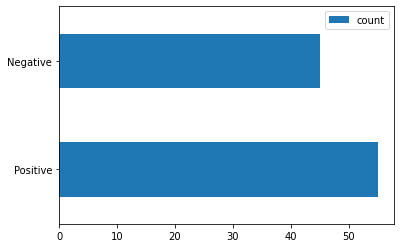

In [25]:
count.plot.barh()
plt.show()

In [26]:
count

,count
Positive,55
Negative,45


In [27]:
result.select("text").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                           |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|foreign firms concerned about operating in taiwan amid chinese military activity                                                                                                                                                 

In [28]:
spark.stop()